In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas_datareader as data
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime
from datetime import time
from pandas.tseries.frequencies import to_offset
import tensorflow as tf
from sklearn import metrics

In [2]:
# Choosing a period which we want to analyze for training and validating
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

# BA boeing company, data from Yahoo finanse
stock_d = data.DataReader('XOM', 'yahoo', start, end)

# week opening
def week_open(array_like):
    return array_like[0]

# week closing
def week_close(array_like):
    return array_like[-1]

# Aplied logic: that opening day is Monday, Closing day is Friday
logic = {
                        # Open - first day (Monday) opening value
                        'Open': week_open, 
                        # High - max value of the period
                         'High': 'max',
                        # Low - min value of the period
                         'Low': 'min',
                        #  Close - last day closing value (Friday)
                         'Close': week_close,
                         #  Adj Close - last day closing value (Friday)
                         'Adj Close': week_close,
                        #  Volume - sum of period Volume values
                         'Volume': 'sum'}

# Converting daily data to weekly with aplied logic
stock_w = stock_d.resample('W').apply(logic) 
stock_w.index -= to_offset('6D')


df = stock_w[['Open', 'High', 'Low',  'Close', 'Adj Close', 'Volume']] #'Close',

In [3]:
print(df)

                 Open        High        Low       Close   Adj Close  \
Date                                                                   
2000-01-03  39.750000   43.125000  38.250000   42.468750   21.119289   
2000-01-10  42.093750   43.000000  41.406250   41.875000   20.824026   
2000-01-17  41.375000   42.937500  41.187500   42.500000   21.134829   
2000-01-24  42.718750   43.156250  39.437500   39.437500   19.611874   
2000-01-31  39.312500   42.437500  38.937500   40.437500   20.109171   
...               ...         ...        ...         ...         ...   
2022-05-16  88.980003   93.589996  88.970001   91.860001   91.860001   
2022-05-23  92.660004   97.930000  92.320000   97.589996   97.589996   
2022-05-30  98.559998   99.779999  95.709999   99.089996   99.089996   
2022-06-06  99.180000  105.570000  98.669998  100.459999  100.459999   
2022-06-13  97.519997   98.669998  93.919998   94.675003   94.675003   

                 Volume  
Date                     
2000-01-03 

In [4]:
df = df.reset_index()
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.shape)
print(train_dates.tail(15)) #Check last few dates. 

(1172,)
1157   2022-03-07
1158   2022-03-14
1159   2022-03-21
1160   2022-03-28
1161   2022-04-04
1162   2022-04-11
1163   2022-04-18
1164   2022-04-25
1165   2022-05-02
1166   2022-05-09
1167   2022-05-16
1168   2022-05-23
1169   2022-05-30
1170   2022-06-06
1171   2022-06-13
Name: Date, dtype: datetime64[ns]


In [5]:
 X_scaler = StandardScaler()
 Y_scaler = StandardScaler()
 X_data = X_scaler.fit_transform(df[['Open', 'High', 'Low', 'Adj Close', 'Close']])
 Y_data = Y_scaler.fit_transform(df[['Close']]) 

In [6]:
 def custom_ts_multi_data_prep(df, target, start, end, n_past, n_future):
     X = []
     y = []
     start = start + n_past
     if end is None:
         end = len(df) - n_future
     for i in range(start, end):
         indices = range(i-n_past, i)
         X.append(df[indices])
         indicey = range(i+1, i+1+n_future)
         y.append(target[indicey])
     return np.array(X), np.array(y) 

In [7]:
 n_past = 52
 n_future = 1
 TRAIN_SPLIT = len(df)-300
 x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, n_past, n_future)
 x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, n_past, n_future) 

In [8]:
 print ('Multiple window of past history\n')
 print(x_train[0])
 print ('\n Target horizon\n')
 print (y_train[0]) 

Multiple window of past history

[[-1.45101801 -1.34139294 -1.46709019 -1.47164692 -1.31230238]
 [-1.33023171 -1.34777196 -1.30268333 -1.48886251 -1.34285121]
 [-1.36727284 -1.35096147 -1.31407786 -1.47074089 -1.31069455]
 [-1.29802203 -1.33979818 -1.40523415 -1.55953817 -1.46826217]
 [-1.47356478 -1.37647757 -1.4312788  -1.5305428  -1.41681152]
 [-1.45101801 -1.45302586 -1.56638543 -1.62602188 -1.5968888 ]
 [-1.57985672 -1.48651573 -1.52080729 -1.60962112 -1.56794781]
 [-1.53476317 -1.57901158 -1.63638043 -1.66702468 -1.66924128]
 [-1.67004383 -1.5598745  -1.63963601 -1.59959813 -1.55026165]
 [-1.5927406  -1.44983634 -1.58429113 -1.5800082  -1.51569324]
 [-1.52832124 -1.50246329 -1.52243508 -1.57864121 -1.51328149]
 [-1.53637366 -1.55827975 -1.52406287 -1.5768186  -1.51006583]
 [-1.50899543 -1.4514311  -1.48987927 -1.56588446 -1.49077183]
 [-1.49611156 -1.42113074 -1.43616217 -1.54310527 -1.45057601]
 [-1.46390188 -1.45621537 -1.42802322 -1.55495088 -1.47147784]
 [-1.47356478 -1.51681

In [9]:
 batch_size = 256
 buffer_size = 150
 train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
 train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
 val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
 val_data = val_data.batch(batch_size).repeat()

In [10]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2)) #DELETE
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(n_future))

model.compile(optimizer='adam', loss='mse', metrics='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 52, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 52, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [11]:

model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5) #,  mode='min'
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True,  verbose=0) #mode='min',
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=5,steps_per_epoch=64,validation_data=val_data, validation_steps=64)

Epoch 1/5
64/64 [==============================] - 13s 170ms/step - loss: 0.2660 - mae: 0.3759 - val_loss: 0.1787 - val_mae: 0.3162
Epoch 2/5
64/64 [==============================] - 11s 177ms/step - loss: 0.0820 - mae: 0.2258 - val_loss: 0.1605 - val_mae: 0.2949
Epoch 3/5
64/64 [==============================] - 12s 181ms/step - loss: 0.0726 - mae: 0.2122 - val_loss: 0.1547 - val_mae: 0.2895
Epoch 4/5
64/64 [==============================] - 11s 177ms/step - loss: 0.0678 - mae: 0.2044 - val_loss: 0.1537 - val_mae: 0.2876
Epoch 5/5
64/64 [==============================] - 11s 180ms/step - loss: 0.0654 - mae: 0.2008 - val_loss: 0.1412 - val_mae: 0.2743


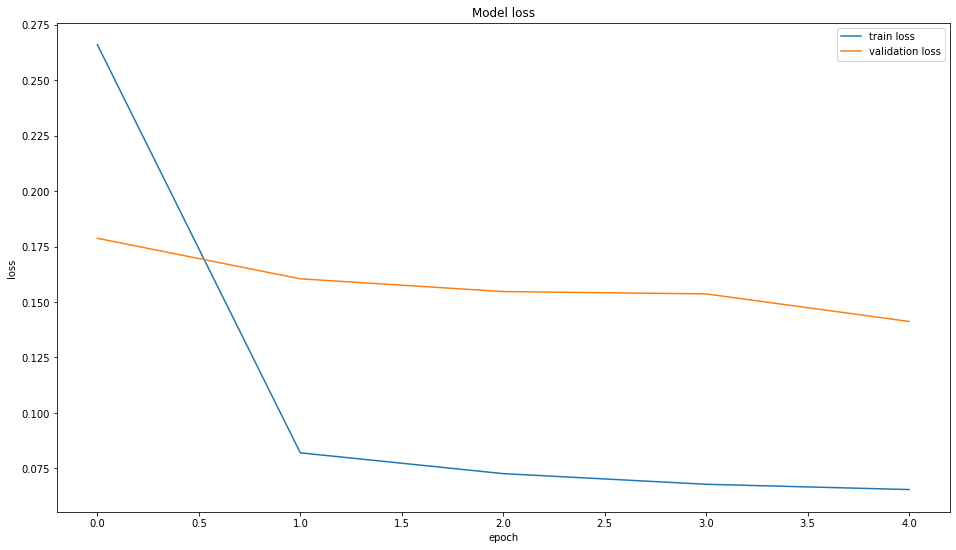

In [12]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [13]:
data_val = X_scaler.fit_transform(df[['Open', 'High', 'Low', 'Adj Close', 'Close']].tail(52))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse 

1/1 [==============================] - 0s 293ms/step


array([[102.030785]], dtype=float32)

In [14]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 
timeseries_evaluation_metrics_func(validate['Close'], pred_Inverse[0])

NameError: name 'validate' is not defined

In [ ]:
pred_Inverse[0]

array([-25.386887], dtype=float32)

In [ ]:
y_true

NameError: name 'y_true' is not defined

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['traffic_volume']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show() 